# Intro

The purpose of this notebook will be to look at the gateway transports here so that we can label the gates with the inflow/outflow in the AW layer

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

# ignore memory warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")

from get_Jterms import *

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [3]:
%run /home/mmurakami/crios_backups/an_helper_functions/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [4]:
# calculate the sea ice edge for 1 and 2
thresh = .15  # 15% sea ice coverage as Barton

fig = plt.figure(figsize=(8,5))

# plot the basins, color by label
landmsk = np.zeros((ny,nx))
landmsk[np.isnan(hfC[0])] = 2
landmsk[hfC[0] == 1] = np.nan

# add the land
# plt.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap='RdBu')

<Figure size 800x500 with 0 Axes>

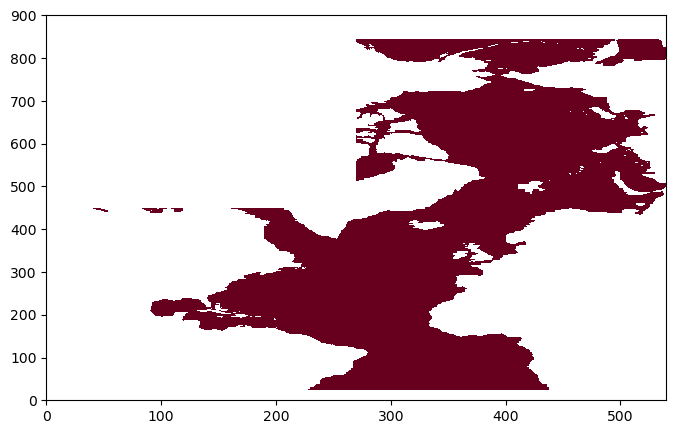

In [5]:
# calculate the sea ice edge for 1 and 2
thresh = .15  # 15% sea ice coverage as Barton

fig = plt.figure(figsize=(8,5))

# plot the basins, color by label
landmsk = np.zeros((ny,nx))
landmsk[np.isnan(hfC[0])] = 2
landmsk[hfC[0] == 1] = np.nan

# add the land
plt.pcolormesh(get_aste_tracer(hfC,nfx,nfy)[0],cmap='RdBu')

# look at the mean surface currents and AW layer currents for 2006--

In [6]:
# ocean and ice
AB_gT=0
AB_gS=0
dt_aste = 600
startyr = 2002
endyr = 2019              # for ASTE R1

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)
allyears = np.arange(2003,2018,1)

In [7]:
dirtrsp = dirrun + "diags/TRSP/"

In [51]:
# overlay on bathymetry
# make one set for DJFM and one set for JJAS

# can do dterm[10:] for AW layer
# can do dterm[:10] for surface layer
# names_title = "DJF"
# months_i = [0,1,11]
# names_title = "MAM"
# months_i = [2,3,4]
# names_title = "JJA"
# months_i = [5,6,7]
names_title = "SON"
months_i = [8,9,10]

all_UVEL = np.zeros((len(allyears[3:]),len(months_i),900,540))
all_VVEL = np.zeros((len(allyears[3:]),len(months_i),900,540))

all_UVEL_top100m = np.zeros((len(allyears[3:]),len(months_i),900,540))
all_VVEL_top100m = np.zeros((len(allyears[3:]),len(months_i),900,540))

iy = 0
for year in allyears[3:]:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ## 
    for i in range(len(months_i)):
        read_tsstr = tsstr[months_i[i]]
        #print(read_tsstr)
    
        # read the fldList
        file_name = 'trsp_3d_set1'
        meta_trsp_3d_set1 = parsemeta(dirtrsp + file_name + "." + read_tsstr + ".meta")
        fldlist = np.array(meta_trsp_3d_set1["fldList"])
        varnames = np.array(["UVELMASS","VVELMASS"])
        recs = np.array([])
        #print(fldlist)
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        UVELi,its,meta = rdmds(os.path.join(dirtrsp, file_name),int(read_tsstr),returnmeta=True,rec=recs[0])  # m/s
        UVELi = np.reshape(UVELi,(nz,ny,nx))
        VVELi,its,meta = rdmds(os.path.join(dirtrsp, file_name),int(read_tsstr),returnmeta=True,rec=recs[1])  # m/s
        VVELi = np.reshape(VVELi,(nz,ny,nx))

        # get the vector
        Uo,Vo = get_aste_vector_face1_3(UVELi,VVELi,nfx,nfy,False)
        Uo,Vo = Uo[:,:-1,:-1],Vo[:,:-1,:-1]     # centering

        # do depth averaging dependent on where you want
        Uo_AW = np.nanmean(Uo[10:],axis=0)
        Vo_AW = np.nanmean(Vo[10:],axis=0)
        Uo_ArW = np.nanmean(Uo[:10],axis=0)
        Vo_ArW = np.nanmean(Vo[:10],axis=0)

        # do averaging in depth and set in bigger array
        all_UVEL[iy,i] = Uo_AW
        all_VVEL[iy,i] = Vo_AW
        all_UVEL_top100m[iy,i] = Uo_ArW
        all_VVEL_top100m[iy,i] = Vo_ArW
    
    iy += 1

2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [52]:
# do averaging
all_UVEL_avg = np.nanmean(all_UVEL,axis=(0,1))
all_VVEL_avg = np.nanmean(all_VVEL,axis=(0,1))

In [53]:
all_UVEL_avg_top100m = np.nanmean(all_UVEL_top100m,axis=(0,1))
all_VVEL_avg_top100m = np.nanmean(all_VVEL_top100m,axis=(0,1))

In [54]:
mymsk = np.zeros((ny,nx))
idxs = np.where(mskBasin == 6)

for i,j in zip (idxs[0],idxs[1]):
    mymsk[i,j] = 1

test = get_aste_tracer(mymsk,nfx,nfy)[0]
test[test == 0] = np.nan

In [55]:
all_UVEL_avg_msk = all_UVEL_avg * test
all_VVEL_avg_msk = all_VVEL_avg * test
all_UVEL_avg_top100m_msk = all_UVEL_avg_top100m * test
all_VVEL_avg_top100m_msk = all_VVEL_avg_top100m * test

In [56]:
# fig = plt.figure(figsize=(8,4))
# step = 6
# scale2 = 1e0
# scale = 2e-1
# U=0.1

# # create spacing for these
# X, Y = np.meshgrid(np.arange(all_UVEL_avg.shape[1]), np.arange(all_VVEL_avg.shape[0]))  # Adjust for your grid

# ax = plt.subplot(121)
# ax.pcolormesh(get_aste_tracer(mygrid['Depth'],nfx,nfy)[0],cmap="rainbow_r",vmin=0,vmax=600,alpha=.6)
# q = ax.quiver(X[::step, ::step], Y[::step, ::step], all_UVEL_avg_msk[::step, ::step], all_VVEL_avg_msk[::step, ::step],color='black',width=0.01,zorder=2,scale=scale,alpha=0.7)
# ax.quiverkey(q, X=.7, Y=.1, U=U, label=f"{U} m/s", labelpos='E',zorder=10)
# ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=2,vmin=0,vmax=6)
# ax.set_xlim(400,540)
# ax.set_ylim(400,600)
# ax.set_title(">100m velocity")


# ax = plt.subplot(122)
# ax.pcolormesh(get_aste_tracer(mygrid['Depth'],nfx,nfy)[0],cmap="rainbow_r",vmin=0,vmax=600,alpha=.6)
# q = ax.quiver(X[::step, ::step], Y[::step, ::step], all_UVEL_avg_top100m_msk[::step, ::step], all_VVEL_avg_top100m_msk[::step, ::step],color='black',width=0.01,zorder=2,scale=scale2,alpha=0.7)
# ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=2,vmin=0,vmax=6)
# ax.quiverkey(q, X=.7, Y=.1, U=U, label=f"{U} m/s", labelpos='E',zorder=10)

# ax.set_xlim(400,540)
# ax.set_ylim(400,600)
# ax.set_title("0-100m velocity")

# plt.suptitle("DJF Average Mass Weighted Velocity (m/s)")

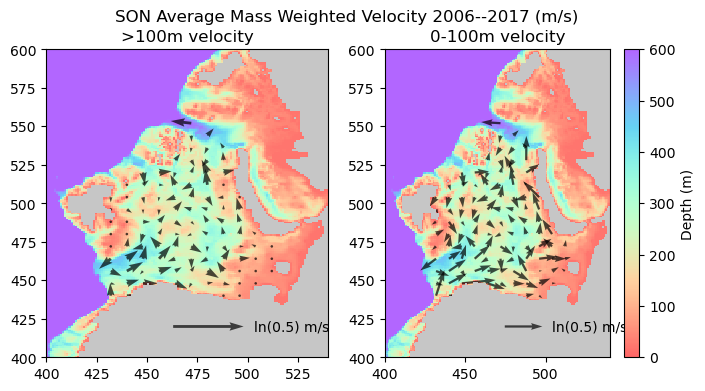

In [57]:
# do same for arctic water layer

mag = np.hypot(all_UVEL_avg_msk, all_VVEL_avg_msk)

# Normalize the vectors by their magnitude
U_norm = all_UVEL_avg_msk / (mag + 1e-10)
V_norm = all_VVEL_avg_msk / (mag + 1e-10)

# Apply square root scaling (or np.log1p for log)
mag_scaled = np.sqrt(mag)  # or np.log1p(mag)

# Now multiply back
U_vis = U_norm * mag_scaled
V_vis = V_norm * mag_scaled

fig = plt.figure(figsize=(8,4))
step = 8
scale2 = 3e0
scale = 2e0
U=0.5

# create spacing for these
X, Y = np.meshgrid(np.arange(all_UVEL_avg.shape[1]), np.arange(all_VVEL_avg.shape[0]))  # Adjust for your grid

ax = plt.subplot(121)
ax.pcolormesh(get_aste_tracer(mygrid['Depth'],nfx,nfy)[0],cmap="rainbow_r",vmin=0,vmax=600,alpha=.6)
q = ax.quiver(X[::step, ::step], Y[::step, ::step], U_vis[::step, ::step], V_vis[::step, ::step],color='black',width=0.01,zorder=2,scale=scale,alpha=0.7)
ax.quiverkey(q, X=.7, Y=.1, U=U, label=f"ln({U}) m/s", labelpos='E',zorder=10)
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=2,vmin=0,vmax=6)
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title(">100m velocity")


mag = np.hypot(all_UVEL_avg_top100m_msk, all_VVEL_avg_top100m_msk)

# Normalize the vectors by their magnitude
U_norm = all_UVEL_avg_top100m_msk / (mag + 1e-10)
V_norm = all_VVEL_avg_top100m_msk / (mag + 1e-10)

# Apply square root scaling (or np.log1p for log)
mag_scaled = np.sqrt(mag)  # or np.log1p(mag)

# Now multiply back
U_vis1 = U_norm * mag_scaled
V_vis1 = V_norm * mag_scaled

ax = plt.subplot(122)
cb = ax.pcolormesh(get_aste_tracer(mygrid['Depth'],nfx,nfy)[0],cmap="rainbow_r",vmin=0,vmax=600,alpha=.6)
q = ax.quiver(X[::step, ::step], Y[::step, ::step], U_vis1[::step, ::step], V_vis1[::step, ::step],color='black',width=0.01,zorder=2,scale=scale2,alpha=0.7)
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=2,vmin=0,vmax=6)
ax.quiverkey(q, X=.7, Y=.1, U=U, label=f"ln({U}) m/s", labelpos='E',zorder=10)
plt.colorbar(cb,label="Depth (m)")

ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("0-100m velocity")


plt.suptitle(names_title+ " Average Mass Weighted Velocity 2006--2017 (m/s)")
plt.savefig("figs/vel2006_2017_" + names_title + ".png",dpi=300)